In [1]:
import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv3D, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.applications import DenseNet121, densenet
from tensorflow.keras import Model
from tensorflow.keras.backend import argmax


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
imdir_train = '/content/gdrive/MyDrive/MMAI 894 Team Project/Train/'
imdir_test = '/content/gdrive/MyDrive/MMAI 894 Team Project/Test/'
img_size = (224, 224)

#import train and validation images
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imdir_train,
    label_mode="int",
    subset=None,
    seed=1337,
    image_size=img_size,
    batch_size=None,
    shuffle=False
)

#import test images
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imdir_test,
    label_mode="int",
    subset=None,
    seed=1337,
    image_size=img_size,
    batch_size=None,
    shuffle=False
)

Found 8928 files belonging to 5 classes.
Found 2031 files belonging to 5 classes.


In [4]:
# Function to create a train and val split from a data set object
def get_dataset_partitions_tf(ds, ds_size, train_split=0.625, val_split=0.375, shuffle=True, shuffle_size=10000, batch_size=32):
    assert (train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        # Note must set reshuffle_each_iteration to False to avoid data leakage
        ds = ds.shuffle(shuffle_size, seed=12, reshuffle_each_iteration = False)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).batch(batch_size)
    
    return train_ds, val_ds

In [5]:
batch_size = 32

# Get the data set size to calculate the right split
# When batched this is the number of batches not item count
batch_count = train_val_ds.cardinality().numpy()
print(batch_count)

# Split the data into three parts
train_ds, val_ds = get_dataset_partitions_tf(train_val_ds, batch_count, train_split=0.625, 
                                                      val_split=0.375, shuffle=True, shuffle_size=10000, batch_size=batch_size)

#set test_ds into batches
test_ds = test_ds.batch(batch_size)

# Check that the split worked
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())

8928
175
105
64


In [6]:
def build_model():

    #DenseNet121 model pre-trained on ImageNet, using AVG pooling at output, freeze training on first 150 layers
    base_model = DenseNet121(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))
    for layer in base_model.layers[:149]:
      layer.trainable = False
    for layer in base_model.layers[149:]:
      layer.trainable = True
    
    input_layer = keras.layers.Input([224,224,3])

    #use keras' densenet preprocessing to prepare input for DenseNet121 model
    pre_process = keras.applications.densenet.preprocess_input(input_layer)

    x = base_model(pre_process)

    #fully connected layer with 1024 neurons, 25% dropout
    dense1 = Dense(1024, activation='relu')(x)
    do1 = Dropout(0.25, seed=42)(dense1)

    #fully connected layer with 1024 neurons, 25% dropout
    dense2 = Dense(1024, activation='relu')(do1)
    do2 = Dropout(0.25, seed=42)(dense2)
    
    #output layer wiht 5 categories
    output_layer = Dense(5, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))(do2)

    model = Model(input_layer, output_layer)
    model.summary()

    return model

def compile_model(model):

    model.compile(
       #use sparse catgorical crossentropy loss
       loss=keras.losses.sparse_categorical_crossentropy,

       #use Adam gradient descent optimizer, set learning rate to 5e-5
       optimizer=keras.optimizers.Adam(learning_rate=5e-5),
       
       #use accuracy as a metric
       metrics=['accuracy']
    )

    return model

def train_model(model, train, val, epochs = 20):

    #fit model with train data
    history = model.fit(
        train_ds,
        
        #use 32 batch size
        batch_size = 32,
        epochs = epochs,
        
        #verbose training, including validation data
        verbose = 2,
        validation_data = val_ds
    )
    return model, history


def eval_model(model, test):

    #evaluate model with test data
    test_loss, test_accuracy = model.evaluate(
        test,
        verbose = 2
    )

    return test_loss, test_accuracy



In [7]:
model = build_model()
model = compile_model(model)
model, history = train_model(model, train_ds, val_ds)
test_loss, test_accuracy = eval_model(model, test_ds)

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                              

In [8]:
print('Test Accuracy:',test_accuracy)

Test Accuracy: 0.9606105089187622


In [9]:
# Extract the labels from the test data set
Y_test_class = tf.concat([labels for images, labels in test_ds], axis=0)

In [10]:
# Pass the test set directly to the predict function
Y_pred_class = argmax(model.predict(test_ds))

In [11]:
# Import libraries for EDA

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)

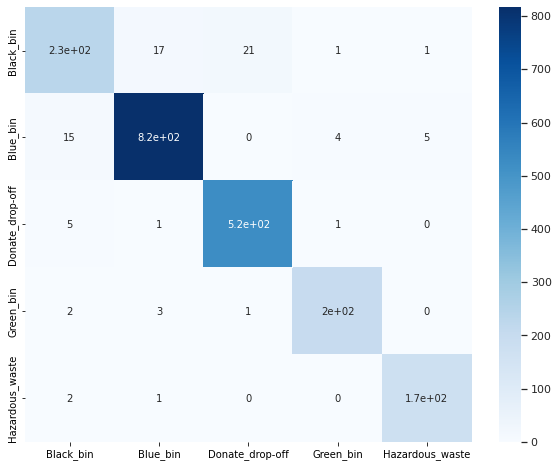

In [12]:
# Generate Confusion Matrix for the 5 Classes
cm=confusion_matrix(Y_test_class,Y_pred_class)
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = train_val_ds.class_names
df_cm.index = train_val_ds.class_names

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size
plt.show()

In [13]:
# Generate Classification Report for the 5 Classes
print(classification_report(Y_test_class,Y_pred_class))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       274
           1       0.97      0.97      0.97       841
           2       0.96      0.99      0.97       532
           3       0.97      0.97      0.97       208
           4       0.97      0.98      0.97       176

    accuracy                           0.96      2031
   macro avg       0.96      0.95      0.95      2031
weighted avg       0.96      0.96      0.96      2031



In [14]:
#narrow down to only recyclable and non-recyclable bins
#0 = non-recyclable
#1 = recycleable
def recycle_classify(labels):
  y = np.copy(labels)
  waste_index = [0,1,0,0,0]
  for i in range(5):
    y = np.where(y == i, waste_index[i], y)
  return y

In [15]:
Y_recycle_class_pred = recycle_classify(Y_pred_class)
Y_recycle_class_test = recycle_classify(Y_test_class)

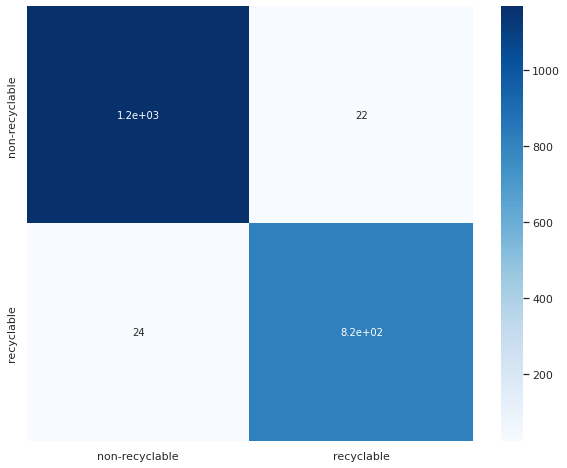

In [16]:
# Generate Confusion Matrix for Recycleable vs. Non-Recyclable

cm=confusion_matrix(Y_recycle_class_test,Y_recycle_class_pred)
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['non-recyclable','recyclable']
df_cm.index = ['non-recyclable','recyclable']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size
plt.show()

In [17]:
# Generate Classification Report for Recycleable vs. Non-Recyclable

print(classification_report(Y_recycle_class_test,Y_recycle_class_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1190
           1       0.97      0.97      0.97       841

    accuracy                           0.98      2031
   macro avg       0.98      0.98      0.98      2031
weighted avg       0.98      0.98      0.98      2031

